# Example: Planewave Absorption Maximization
In this example, we compute bounds on the maximum absorption of an incident planewave by a structure. 

The harmonic time-averaged absorption is

$$
f(\mathbf{e}) = \frac{\omega}{2}  \int \Im(\epsilon(\mathbf{r})) |\mathbf{e}(\mathbf{r})|^2 d \mathbf{r}
$$

Using the fact that $\Im(\epsilon(\mathbf{r})) |\mathbf{e}(\mathbf{r})|^2$ is only non-zero over the structure, we can rewrite this using the polarization field as

$$
f(\mathbf{p}) = \frac{\omega}{2} \Im\left(\chi \frac{\mathbf{p}^\dagger}{\chi^*} \frac{\mathbf{p}}{\chi} \right) = \frac{\omega}{2}\frac{\Im(\chi)}{|\chi|^2} \mathbf{p}^\dagger \mathbf{p}.
$$
Therefore, the constant and linear parts of the objective are $0$, and the quadratic part is $A_0 = -\frac{\omega}{2}\frac{\Im(\chi)}{|\chi|^2} I = \frac{\omega}{2} \Im\left(\frac{1}{\chi} \right) I$. Note the $-$ sign when defining $A_0$: this is because the QCQP class writes the QCQP objective as
$$
\max_{\mathbf{x}} \quad -\mathbf{x}^\dagger A_0 \mathbf{x} + 2\Re(\mathbf{x^\dagger} s_0) + c_0.
$$

In [8]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys, time, os

package_path = os.path.abspath('../../../dolphindes')
if package_path not in sys.path:
    sys.path.append(package_path)

from dolphindes import photonics

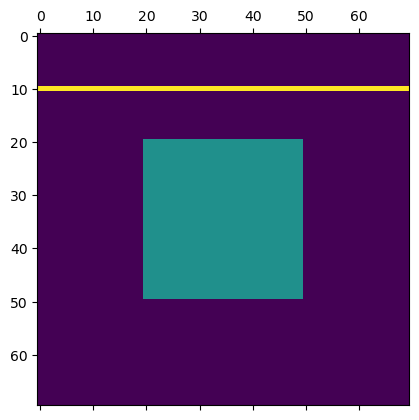

In [9]:
## wavelength, geometry and materials of the planewave absorption problem ##
wavelength = 1.0
omega = 2*np.pi / wavelength

chi = 3 + 1e-2j

px_per_length = 20 # pixels per length unit. If wavelength = 1.0, then this is pixels per wavelength.
dl = 1 / px_per_length

des_x = 1.5
des_y = 1.5 # size of the design region for the absorbing structure
pmlsep = pmlthick = 0.5
Mx = int(des_x / dl)
My = int(des_y / dl)

Npmlsepx = Npmlsepy = int(pmlsep / dl)
Npmlx = Npmly = int(pmlthick / dl)
Nx = Mx + 2*(Npmlsepx + Npmlx)
Ny = My + 2*(Npmlsepy + Npmly)

des_mask = np.zeros((Nx,Ny), dtype=bool)
des_mask[Npmlx+Npmlsepx:-(Npmlx+Npmlsepx) , Npmly+Npmlsepy:-(Npmly+Npmlsepy)] = True
Ndes = int(np.sum(des_mask))

## planewave source
ji = np.zeros((Nx,Ny), dtype=complex)
ji[Npmlx,:] = 2.0 / dl # linesource for unit amplitude planewave traveeling in x direction

plt.matshow(des_mask + np.real(ji)*dl) # visualize where the mask and the source are

In [10]:
## setup the ephotonic TM FDFD class
abs_problem = photonics.Photonics_TM_FDFD(omega=omega, chi=chi, dl=dl,
                                          grid_size=(Nx,Ny), pml_size=(Npmlx,Npmly),
                                          des_mask=des_mask, ji=ji, sparseQCQP=True)

print(abs_problem)

Photonics_TM_FDFD(omega=6.283185307179586, chi=(3+0.01j), Nx=70, Ny=70, Npmlx=10, Npmly=10, dl=0.05, des_mask=True, ji=True, ei=False, chi_background=False, bloch_x=0.0, bloch_y=0.0)


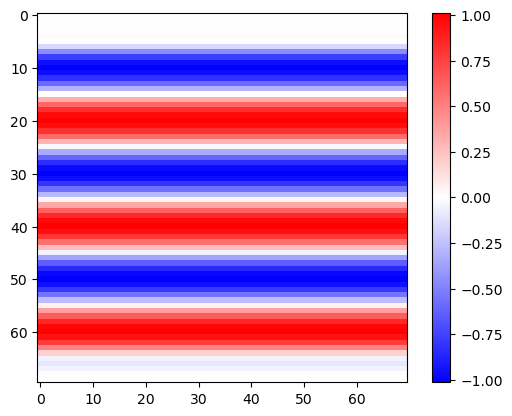

In [11]:
## obtain incident planewave and plot it
ei = abs_problem.get_ei(ji, update=True)
plt.imshow(np.real(ei), cmap='bwr')
plt.colorbar()

In [12]:
## We start by calculating limits with just the global conservation of power constraints
c0 = 0.0
s0 = np.zeros(Ndes, dtype=complex)
A0 = (omega/2) * np.imag(1.0/chi) * sp.eye_array(Ndes) * dl**2 # dl**2 is the resolution factor for integration in 2D
abs_problem.set_objective(s0=s0, A0=A0, c0=c0)
abs_problem.setup_QCQP(Pdiags='global', verbose=1)
result = abs_problem.bound_QCQP('newton')
print(f'global constraint bound is {result[0]}')

Precomputed 2 A matrices for the projectors.
Found feasible point for dual problem: [5.85505053e-07 1.00000000e-01] with dualvalue 17.53046168796042
global constraint bound is 1.6412234071924703


In [13]:
## if desired, we can run generalized constraint descent to tighten the bounds
abs_problem.QCQP.run_gcd()
abs_gcd_bound = abs_problem.QCQP.current_dual

Precomputed 2 A matrices for the projectors.
At GCD iteration #1, best dual bound found is 1.6412234071923448.
At GCD iteration #2, best dual bound found is 1.6063788857502743.
At GCD iteration #3, best dual bound found is 1.5535201191476946.
At GCD iteration #4, best dual bound found is 1.5119850050773262.
At GCD iteration #5, best dual bound found is 1.5054804450937818.
At GCD iteration #6, best dual bound found is 1.492092602673768.
At GCD iteration #7, best dual bound found is 1.48023672812164.
At GCD iteration #8, best dual bound found is 1.4771197858669889.
At GCD iteration #9, best dual bound found is 1.473332402693579.
At GCD iteration #10, best dual bound found is 1.4704160279607168.
At GCD iteration #11, best dual bound found is 1.4669413733090866.
At GCD iteration #12, best dual bound found is 1.4645522530501411.
At GCD iteration #13, best dual bound found is 1.4649466359876688.
At GCD iteration #14, best dual bound found is 1.4609912910514333.
At GCD iteration #15, best dua

In [14]:
print('Bound for maximum absorption power found is', abs_gcd_bound)
Sx = 0.5 # unit amplitude planewave has Poynting vector magnitude of 0.5
print('Ratio between maximum absorption cross section is', abs_gcd_bound / (Sx*des_y)) 

Bound for maximum absorption power found is 1.4616594483247833
Ratio between maximum absorption cross section is 1.9488792644330444
